#### Task 2: Import Libraries and Datasets

In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import string
import nltk

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import and read data
df = pd.read_csv("twitter.csv")

df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
# Drop ID column

df = df.drop(['id'], axis=1)

In [5]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [6]:
df.shape

(31962, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [8]:
df['tweet']

0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, Length: 31962, dtype: object

#### Task 3: Explore Datasets

In [9]:
# Checking for Null values
df.isnull().sum()

label    0
tweet    0
dtype: int64

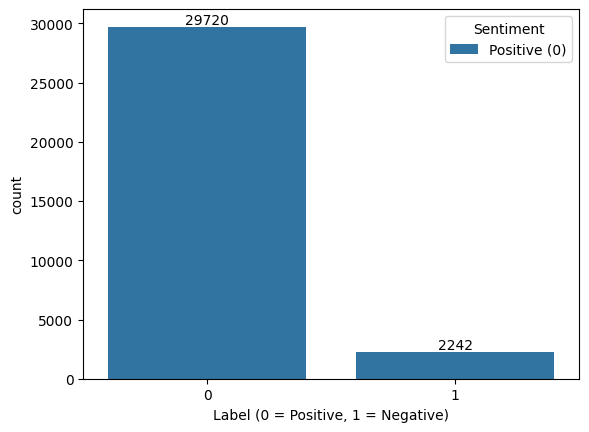

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the plot
ax = sns.countplot(data=df, x='label')

# Add count labels on top of bars
for bars in ax.containers:
    ax.bar_label(bars)

# Add a custom legend
ax.legend(title='Sentiment', labels=['Positive (0)', 'Negative (1)'])

# Set axis label if needed
ax.set_xlabel("Label (0 = Positive, 1 = Negative)")

plt.show()

In [11]:
# get the length of the messages

df['length'] = df['tweet'].apply(len)

In [12]:
df.head()

,label,tweet,length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39


<Axes: ylabel='Frequency'>

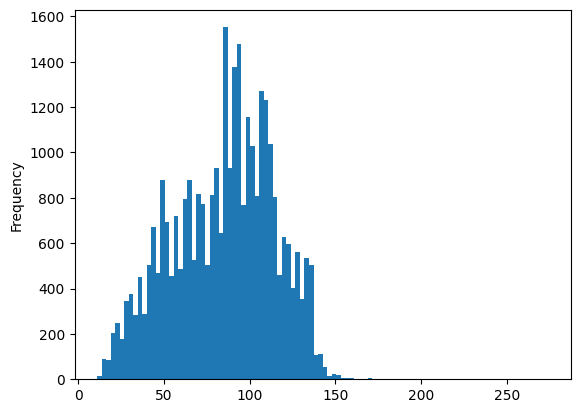

In [13]:
df['length'].plot(bins=100, kind='hist')

In [14]:
df.describe()

,label,length
count,31962.000000,31962.000000
mean,0.070146,84.739628
std,0.255397,29.455749
min,0.000000,11.000000
25%,0.000000,63.000000
50%,0.000000,88.000000
75%,0.000000,108.000000
max,1.000000,274.000000


In [15]:
# The shortest message
df[df['length'] == df['length'].min()]['tweet'].iloc[0]

'i love you '

In [16]:
# View the message with the average length
avg_length = df['length'].mean()
closest_index = (df['length'] - avg_length).abs().idxmin()
df.loc[closest_index, 'tweet']

' â\x86\x9d #under the spell of brexit referendum - commerzbank   #blog #silver #gold #forex'

df['length'].mean() – calculates average tweet length.

(df['length'] - avg_length).abs() – computes how far each tweet is from the average.

.idxmin() – finds the index of the tweet closest to the average length.

df.loc[closest_index, 'tweet'] – returns that tweet.

In [17]:
# Positive Tweets

positive = df[df['label'] == 0]

positive.head()

,label,tweet,length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39


In [18]:
# Negative Tweets

negative = df[df['label'] == 1]

negative.head()

,label,tweet,length
13,1,@user #cnn calls #michigan middle school 'buil...,74
14,1,no comment! in #australia #opkillingbay #se...,101
17,1,retweet if you agree!,22
23,1,@user @user lumpy says i am a . prove it lumpy.,47
34,1,it's unbelievable that in the 21st century we'...,104


In [19]:
len(positive)

29720

In [20]:
len(negative)

2242

#### Task 4: Plot the WordCloud

In [21]:
sentences = df['tweet'].tolist()  # converts the Series into a Python list.

In [22]:
sentences

[' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
 '  bihday your majesty',
 '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
 ' factsguide: society now    #motivation',
 '[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  ',
 ' @user camping tomorrow @user @user @user @user @user @user @user dannyâ\x80¦',
 "the next school year is the year for exams.ð\x9f\x98¯ can't think about that ð\x9f\x98\xad #school #exams   #hate #imagine #actorslife #revolutionschool #girl",
 'we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â\x80¦ ',
 " @user @user welcome here !  i'm   it's so #gr8 ! ",
 ' â\x86\x9d #ireland consume

In [23]:
len(sentences)

31962

In [24]:
sentences_as_one_string = " ".join(sentences)

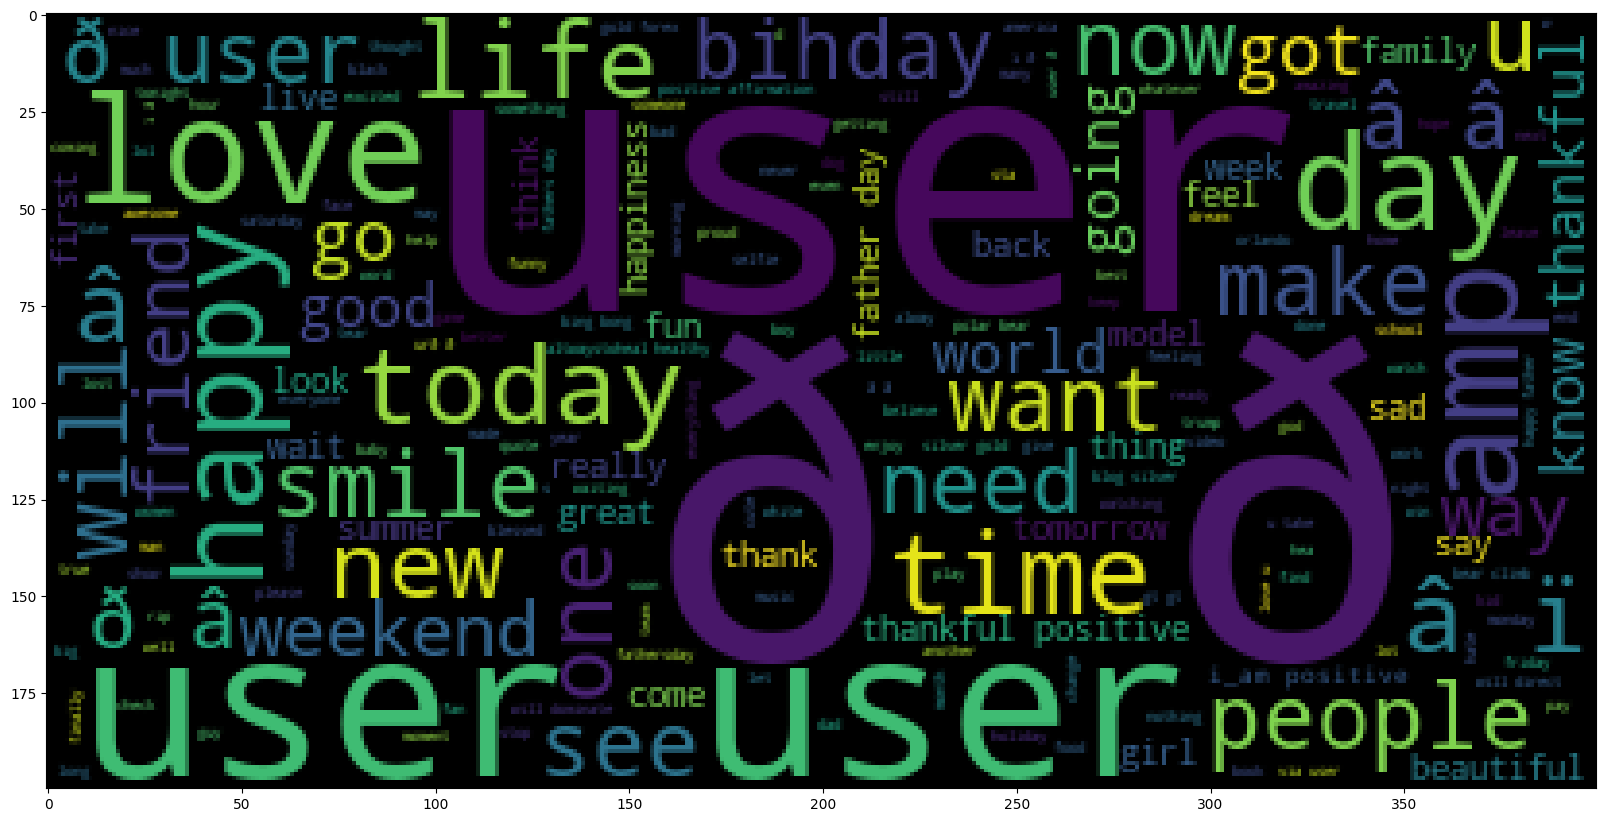

In [25]:
from wordcloud import WordCloud

plt.figure(figsize=(20, 20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

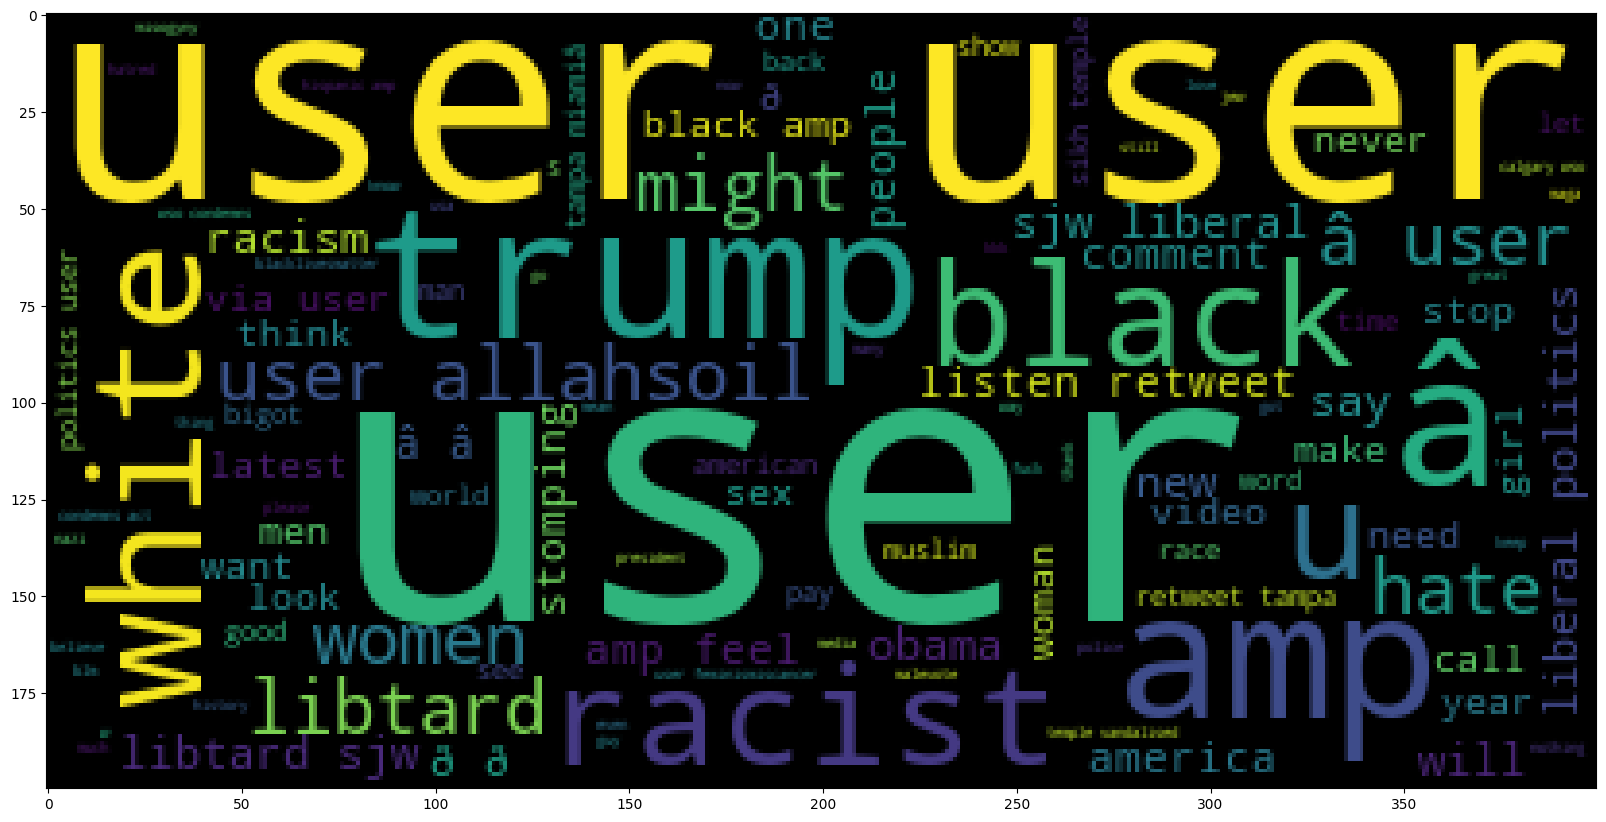

In [26]:
# Plot the WordCloud for "negative" dataframe

negative_list = negative['tweet'].tolist()
negative_sentences_as_one_string = " ".join(negative_list)
plt.figure(figsize=(20, 20))
plt.imshow(WordCloud().generate(negative_sentences_as_one_string))

#### Task 5: Perform Data Cleaning - Remove Punctuation From Text

In [27]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [28]:
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

df['tweet'] = df['tweet'].apply(remove_punctuation)

In [29]:
df.head()

,label,tweet,length
0,0,user when a father is dysfunctional and is so...,102
1,0,user user thanks for lyft credit i cant use ca...,122
2,0,bihday your majesty,21
3,0,model i love u take with u all the time in u...,86
4,0,factsguide society now motivation,39


#### Task 6: Perform Data Cleaning -  Remove Stop Words

In [30]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered)

df['tweet'] = df['tweet'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kshit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
df.head()

,label,tweet,length
0,0,user father dysfunctional selfish drags kids d...,102
1,0,user user thanks lyft credit cant use cause do...,122
2,0,bihday majesty,21
3,0,model love u take u time urð± ðððð...,86
4,0,factsguide society motivation,39


#### Task 7: Perform Count Vectorization (Tokenization)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer